In [1]:
import sys
sys.path.append('..')
from searchutil import *
from judgements import *
import os
from IPython.display import display,HTML
from pyspark.sql import SparkSession
from solrclient import *
from solr import *
spark = SparkSession.builder.appName("setting-datasets").getOrCreate()
client = SolrClient(solr_base=SOLR_URL)

In [2]:
# For reloading external files
%load_ext autoreload
%autoreload 2

## Downloading the datasets for the Products Data

In [3]:

#Have downloaded the datasets of the products and signals and stored it in data folder.
! cd data/retrotech/&& head products.csv

"upc","name","manufacturer","shortDescription","longDescription"
"096009010836","Fists of Bruce Lee - Dolby - DVD",\N,\N,\N
"043396061965","The Professional - Widescreen Uncut - DVD",\N,\N,\N
"085391862024","Pokemon the Movie: 2000 - DVD",\N,\N,\N
"067003016025","Summerbreeze - CD","Nettwerk",\N,\N
"731454813822","Back for the First Time [PA] - CD","Def Jam South",\N,\N
"024543008200","Big Momma's House - Widescreen - DVD",\N,\N,\N
"031398751823","Kids - DVD",\N,\N,\N
"037628413929","20 Grandes Exitos - CD","Sony Discos Inc.",\N,\N
"060768972223","Power Of Trinity (Box) - CD","Sanctuary Records",\N,\N


## Storing Products dataset to Apache Solr using Spark Read CSV

In [4]:
#Create Products Collection
products_collection="products"
create_collection(products_collection)

#Modify Schema to make some fields explicitly searchable by keyword
upsert_text_field(products_collection, "upc")
upsert_text_field(products_collection, "name")
upsert_text_field(products_collection, "longDescription")
upsert_text_field(products_collection, "manufacturer")

print("Loading Products...")
csvFile = "data/retrotech/products.csv"
csvDF = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(csvFile)
print("Products Schema: ")
csvDF.printSchema()

product_update_opts={"zkhost": "search-zk", "collection": products_collection, 
                     "gen_uniq_key": "true", "commit_within": "5000"}
csvDF.write.format("solr").options(**product_update_opts).mode("overwrite").save()
print("Status: Success")

Wiping 'products' collection
[('action', 'CREATE'), ('name', 'products'), ('numShards', 1), ('replicationFactor', 1)]
Creating 'products' collection
Status: Success
Adding 'upc' field to collection
Status: Success
Adding 'name' field to collection
Status: Success
Adding 'longDescription' field to collection
Status: Success
Adding 'manufacturer' field to collection
Status: Success
Loading Products...
Products Schema: 
root
 |-- upc: long (nullable = true)
 |-- name: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- shortDescription: string (nullable = true)
 |-- longDescription: string (nullable = true)

Status: Success


## Searching in Apache Solr and checking if results are right

In [5]:
query = "ipod"

collection = "products"
request = {
    "query": query,
    "fields": ["upc", "name", "manufacturer", "score"],
    "limit": 5,
    "params": {
      "qf": "name manufacturer longDescription",
      "defType": "edismax",
      "sort": "score desc, upc asc"
    }
}

search_results = requests.post(f"{SOLR_URL}/{collection}/select", json=request).json()["response"]["docs"]
display(HTML(render_search_results(query, search_results)))

## Downloading and checking Signals Dataset

In [6]:
! cd data/retrotech/&& head signals.csv

"query_id","user","type","target","signal_time"
"u2_0_1","u2","query","nook","2019-07-31 08:49:07.3116"
"u2_1_2","u2","query","rca","2020-05-04 08:28:21.1848"
"u3_0_1","u3","query","macbook","2019-12-22 00:07:07.0152"
"u4_0_1","u4","query","Tv antenna","2019-08-22 23:45:54.1030"
"u5_0_1","u5","query","AC power cord","2019-10-20 08:27:00.1600"
"u6_0_1","u6","query","Watch The Throne","2019-09-18 11:59:53.7470"
"u7_0_1","u7","query","Camcorder","2020-02-25 13:02:29.3089"
"u9_0_1","u9","query","wireless headphones","2020-04-26 04:26:09.7198"
"u10_0_1","u10","query","Xbox","2019-09-13 16:26:12.0132"


## Ingesting Signals Dataset to Solr Database

In [7]:
#Create Signals Collection
signals_collection="signals"
create_collection(signals_collection)

print("Loading Signals...")
csvFile = "data/retrotech/signals.csv"
csvDF = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(csvFile)
print("Signals Schema: ")
csvDF.printSchema()

signals_update_opts={"zkhost": "search-zk", "collection": signals_collection, 
                     "gen_uniq_key": "true", "commit_within": "5000"}
csvDF.write.format("solr").options(**signals_update_opts).mode("overwrite").save()
print("Status: Success")

Wiping 'signals' collection
[('action', 'CREATE'), ('name', 'signals'), ('numShards', 1), ('replicationFactor', 1)]
Creating 'signals' collection
Status: Success
Loading Signals...
Signals Schema: 
root
 |-- query_id: string (nullable = true)
 |-- user: string (nullable = true)
 |-- type: string (nullable = true)
 |-- target: string (nullable = true)
 |-- signal_time: timestamp (nullable = true)

Status: Success


## Boosting the signals

In [8]:
products_collection="products"
signals_collection="signals"
signals_boosting_collection="signals_boosting"

create_collection(signals_boosting_collection)

print("Aggregation to Create Signals Boosts...")
signals_opts={"zkhost": "search-zk", "collection": signals_collection}
df = spark.read.format("solr").options(**signals_opts).load()
df.createOrReplaceTempView("signals")

# For each query we are storing how many times the document has been clicked.
signals_aggregation_query = """
select q.target as query, c.target as doc, count(c.target) as boost
  from signals c left join signals q on c.query_id = q.query_id
  where c.type = 'click' AND q.type = 'query'
  group by query, doc
  order by boost desc
"""

signals_boosting_opts={"zkhost": "search-zk", "collection": signals_boosting_collection, 
                       "gen_uniq_key": "true", "commit_within": "5000"}

#Writing the Boosted Signal Information to Apache Spark
spark.sql(signals_aggregation_query).write.format("solr").options(**signals_boosting_opts).mode("overwrite").save()
print("Signals Aggregation Completed!")

Wiping 'signals_boosting' collection
[('action', 'CREATE'), ('name', 'signals_boosting'), ('numShards', 1), ('replicationFactor', 1)]
Creating 'signals_boosting' collection
Status: Success
Aggregation to Create Signals Boosts...
Signals Aggregation Completed!


## For the query ipad, collecting the documents and their boosts

In [12]:
query = "ipad"

signals_boosts_query = {
    "query": query,
    "fields": ["doc", "boost"],
    "limit": 10,
    "params": {
      "defType": "edismax",
      "qf": "query",
      "sort": "boost desc"
    }
}

signals_boosts = requests.post(f"{SOLR_URL}/{signals_boosting_collection}/select", 
                               json=signals_boosts_query).json()["response"]["docs"]
print(f"Boost Documents for the query ipad: \n{signals_boosts}")

Boost Documents for the query ipad: 
[{'doc': '885909457588', 'boost': 943}, {'doc': '885909457595', 'boost': 201}, {'doc': '885909471812', 'boost': 197}, {'doc': '886111287055', 'boost': 106}, {'doc': '843404073153', 'boost': 69}, {'doc': '885909472376', 'boost': 61}, {'doc': '885909457601', 'boost': 60}, {'doc': '635753493559', 'boost': 59}, {'doc': '610839379408', 'boost': 28}, {'doc': '635753490879', 'boost': 27}]


## Searching the products collection with this boost values from User clicks data

In [13]:
product_boosts = " ".join(
    [f'"{entry["doc"]}"^{str(entry["boost"])}' 
     for entry in signals_boosts])
print(f"\nBoost Query: \n{product_boosts}")

collection = "products"
request = {
    "query": query,
    "fields": ["upc", "name", "manufacturer", "score"],
    "limit": 5,
    "params": {
      "qf": "name manufacturer longDescription",
      "defType": "edismax",
      "indent": "true",
      "sort": "score desc, upc asc",
      "qf": "name manufacturer longDescription",
      "boost": "sum(1,query({! df=upc v=$signals_boosting}))",
      "signals_boosting": product_boosts
    }
}

search_results = requests.post(f"{SOLR_URL}/{collection}/select", json=request).json()["response"]["docs"]
display(HTML(render_search_results(query, search_results)))


Boost Query: 
"885909457588"^943 "885909457595"^201 "885909471812"^197 "886111287055"^106 "843404073153"^69 "885909472376"^61 "885909457601"^60 "635753493559"^59 "610839379408"^28 "635753490879"^27


# Searching with the related keywords

The basic intuition is if user 1 types a query q1 and clicks product p and if user 2 types a query q2 and clicks on same product, we can assume that both queries q1 and q2 are related.

In [14]:
#Calculation:
spark.sql("""
  select lower(searches.target) as keyword, searches.user as user, clicks.target as product 
  from signals as searches right join signals as clicks on searches.query_id = clicks.query_id 
  where searches.type='query' and clicks.type = 'click'
""").createOrReplaceTempView('keyword_click_product')


In [15]:
#Show Results:
print("Original signals format: ")
spark.sql(''' select * from signals where type='query' ''').show(3, truncate=False)
print("Simplified signals format: ")
spark.sql(''' select * from keyword_click_product ''').show(3)

Original signals format: 
+------------------------------------+-----------+-----------------------+------------------+-----+-------+
|id                                  |query_id   |signal_time            |target            |type |user   |
+------------------------------------+-----------+-----------------------+------------------+-----+-------+
|00001915-c0ef-4617-b907-8d944d11576d|u580663_0_1|2020-03-28 07:12:18.894|Iphone            |query|u580663|
|000081e2-497f-4975-8f31-2f94b6f38e80|u465348_0_1|2020-04-22 12:39:44.931|Batman Arkham City|query|u465348|
|00014a37-a0cf-411b-bd47-6f6ff1cf854c|u98598_0_1 |2019-12-31 11:52:57.115|Beats             |query|u98598 |
+------------------------------------+-----------+-----------------------+------------------+-----+-------+
only showing top 3 rows

Simplified signals format: 
+----------------+-------+------------+
|         keyword|   user|     product|
+----------------+-------+------------+
|        kingston|u100001|740617151381|
|    

In [16]:
#Calculation:
spark.sql("""
select k1.keyword as k1, k2.keyword as k2, sum(p1) n_users1,sum(p2) n_users2, 
sum(p1+p2) as users_cooc, count(1) n_products
from
(select keyword, product, count(1) as p1 from keyword_click_product group by keyword, product) as k1 
join
(select keyword, product, count(1) as p2 from keyword_click_product group by keyword, product) as k2
on k1.product = k2.product
where k1.keyword > k2.keyword 
group by k1.keyword, k2.keyword
""").createOrReplaceTempView('keyword_click_product_cooc')

In [17]:
#Show Results:
spark.sql('''select count(1) as keyword_click_product_cooc from keyword_click_product_cooc''').show()
spark.sql('''select * from keyword_click_product_cooc order by n_products desc''').show(20)

+--------------------------+
|keyword_click_product_cooc|
+--------------------------+
|                   1579710|
+--------------------------+

+--------------+-------------+--------+--------+----------+----------+
|            k1|           k2|n_users1|n_users2|users_cooc|n_products|
+--------------+-------------+--------+--------+----------+----------+
|       laptops|       laptop|    3251|    3345|      6596|       187|
|       tablets|       tablet|    1510|    1629|      3139|       155|
|        tablet|         ipad|    1468|    7067|      8535|       146|
|       tablets|         ipad|    1359|    7048|      8407|       132|
|       cameras|       camera|     637|     688|      1325|       116|
|          ipad|        apple|    6706|    1129|      7835|       111|
|      iphone 4|       iphone|    1313|    1754|      3067|       108|
|    headphones|  head phones|    1829|     492|      2321|       106|
|     computers|     computer|     536|     392|       928|        98|
| 

In [18]:
#Calculation:
spark.sql("""
select keyword, count(1) as n_users from keyword_click_product group by keyword 
""").createOrReplaceTempView('keyword_click_product_oc')

In [19]:
#Show Results:
spark.sql('''select count(1) as keyword_click_product_oc from keyword_click_product_oc''').show()
spark.sql('''select * from keyword_click_product_oc order by n_users desc''').show(20)

+------------------------+
|keyword_click_product_oc|
+------------------------+
|                   13744|
+------------------------+

+------------+-------+
|     keyword|n_users|
+------------+-------+
|        ipad|   7554|
| hp touchpad|   4829|
|      lcd tv|   4606|
|   iphone 4s|   4585|
|      laptop|   3554|
|       beats|   3498|
|     laptops|   3369|
|        ipod|   2949|
|  ipod touch|   2931|
|      ipad 2|   2842|
|      kindle|   2833|
|    touchpad|   2785|
|   star wars|   2564|
|      iphone|   2430|
|beats by dre|   2328|
|     macbook|   2313|
|  headphones|   2270|
|        bose|   2071|
|         ps3|   2041|
|         mac|   1851|
+------------+-------+
only showing top 20 rows



In [20]:
# calculate PMI2

#Calculation:
spark.sql('''
select k1.keyword as k1, k2.keyword as k2, k1_k2.users_cooc, k1.n_users as n_users1,k2.n_users as n_users2,
log(pow(k1_k2.users_cooc,2)/(k1.n_users*k2.n_users)) as pmi2
from
keyword_click_product_cooc as k1_k2 
join
keyword_click_product_oc as k1 on k1_k2.k1 = k1.keyword
join
keyword_click_product_oc as k2 on k1_k2.k2 = k2.keyword
''').createOrReplaceTempView('product_related_keywords_pmi')

In [21]:
#Show Results:
spark.sql('''select count(1) as related_keywords_pmi from product_related_keywords_pmi''').show()
spark.sql('''select * from product_related_keywords_pmi order by pmi2 desc''').show(20)

+--------------------+
|related_keywords_pmi|
+--------------------+
|             1579710|
+--------------------+

+-------------------+-------------------+----------+--------+--------+------------------+
|                 k1|                 k2|users_cooc|n_users1|n_users2|              pmi2|
+-------------------+-------------------+----------+--------+--------+------------------+
|        hp touchpad|    hp tablet 32 gb|      4022|    4829|       1| 8.116674454791653|
|          pad pivot|        hp touchpad|      4022|       1|    4829| 8.116674454791653|
|     hp touchpad 32|        hp touchpad|      4022|       1|    4829| 8.116674454791653|
|        hp touchpad|     hp tablet 32gb|      4022|    4829|       1| 8.116674454791653|
|           touchpad|          pad pivot|      2350|    2785|       1| 7.592338061915025|
|           touchpad|    hp tablet 32 gb|      2350|    2785|       1| 7.592338061915025|
|           touchpad|     hp tablet 32gb|      2350|    2785|       1| 7.5

In [22]:
# calculate comp_score

#Calculation:
spark.sql('''
select  *, (r1 + r2 /( r1 * r2))/2 as comp_score from (
 select *, 
   rank() over (partition by 1 order by users_cooc desc )  r1 , 
   rank() over (partition by 1 order by pmi2 desc )  r2  
  from product_related_keywords_pmi ) a  '''
).createOrReplaceTempView('product_related_keywords_comp_score')

In [23]:
#Show Results:
spark.sql( '''
  select count(1) product_related_keywords_comp_scores from product_related_keywords_comp_score
''').show()

spark.sql( '''
  select k1, k2, n_users1, n_users2, pmi2, comp_score 
  from product_related_keywords_comp_score
  order by comp_score asc
''').show(20)

+------------------------------------+
|product_related_keywords_comp_scores|
+------------------------------------+
|                             1579710|
+------------------------------------+

+----------+-----------+--------+--------+------------------+------------------+
|        k1|         k2|n_users1|n_users2|              pmi2|        comp_score|
+----------+-----------+--------+--------+------------------+------------------+
|      ipad|hp touchpad|    7554|    4829|1.2318940540272372|               1.0|
|    ipad 2|       ipad|    2842|    7554| 1.430517155037946|              1.25|
|    tablet|       ipad|    1818|    7554|1.6685364924472557|1.6666666666666667|
|  touchpad|       ipad|    2785|    7554|1.2231908670315748|             2.125|
|   tablets|       ipad|    1627|    7554|1.7493143317791537|               2.6|
|     ipad2|       ipad|    1254|    7554|1.9027023623302282|3.0833333333333335|
|      ipad|      apple|    7554|    1814|1.4995901756327583|3.571428571428

We can see above that the related keywords are k1 and k2. The low comp_score indicates that they are closely related keywords. We can see that our results are giving somewhat semantically related keywords.

## To find the wrongly spelled words

In [24]:
import nltk
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import numpy as np
import re
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
import json

In [26]:
collection="products"
query="moden"

request = {
    "params": {
        "q.op": "and",
        "rows": 0,
        "indent": "on"
    },
    "query": query,
}

search_results = requests.post(f"{SOLR_URL}/{collection}/spell", json=request).json()
print(json.dumps(search_results["spellcheck"]["collations"], indent=4))

[]


In [27]:
#use the real signals
signals_collection="signals"
signals_opts={"zkhost": "search-zk", "collection": signals_collection}
df = spark.read.format("solr").options(**signals_opts).load()
df.createOrReplaceTempView("signals")

In [28]:
### Create user-searchs table each raw represent one search query.
query_signals = spark.sql("""
  select lower(trim(searches.target)) as keyword, searches.user as user 
  from signals as searches where searches.type='query'
  group by keyword, user"""
).collect()

### Now we tokenise the queries and find word frequencies. For the frequency distribution quantiles, we can choose the cutoff point to get only useful misspellings

In [29]:
stop_words = set(stopwords.words('english'))
word_list = defaultdict(int)

for row in query_signals:
    query = row["keyword"]
    tokenizer = RegexpTokenizer(r'\w+') 
    tokens   = tokenizer.tokenize(query)
    
    for token in tokens:
        if token not in stop_words and len(token) > 3 and not token.isdigit():  #drop stopwords and digit only tokens
            # and only consider token length > 3, since hard to judge whether a very short token is misspelled or not
            word_list[token] += 1

In [30]:
quantiles_to_check = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
quantile_values = np.quantile(np.array(list(word_list.values())), quantiles_to_check)
quantiles = dict(zip(quantiles_to_check, quantile_values))
quantiles

{0.1: 5.0,
 0.2: 6.0,
 0.3: 8.0,
 0.4: 12.0,
 0.5: 16.0,
 0.6: 25.0,
 0.7: 47.0,
 0.8: 142.20000000000027,
 0.9: 333.2000000000007}

In [31]:
misspell_candidates = []
correction_candidates = []
misspell_counts = []
correction_counts = []
misspell_length = []
correction_length = []
misspell_initial = []
correction_initial = []


#consider word with low count as misspelling condidates, with high count as correctly spelled candidates. 
for k, v in word_list.items():
    if v <= quantiles[0.2] : #if v == 1:  # this number based on quantile analysis and the data set, more-likely with user-behvaiour data set to be 1
        misspell_candidates.append(k)
        misspell_counts.append(v)
        misspell_length.append(len(k))
        misspell_initial.append(k[0])
    if v >= quantiles[0.8]:
        correction_candidates.append(k)
        correction_counts.append(v)
        correction_length.append(len(k))
        correction_initial.append(k[0])

In [32]:
misspell_candidates_df = pd.DataFrame({
    "misspell":misspell_candidates, 
    "misspell_counts":misspell_counts, 
    "misspell_length":misspell_length,
    "initial":misspell_initial})

correction_candidates_df = pd.DataFrame({
    "correction":correction_candidates, 
    "correction_counts":correction_counts, 
    "correction_length":correction_length,
    "initial":correction_initial})

In [33]:
#Show Results:
misspell_candidates_df.head(10)

,misspell,misspell_counts,misspell_length,initial
0,luther,6,6,l
1,vandross,6,8,v
2,gorillaz,6,8,g
3,livewire,6,8,l
4,hubs,6,4,h
5,conchords,6,9,c
6,financial,6,9,f
7,cruzer,6,6,c
8,aids,6,4,a
9,slots,6,5,s


We calculate the edit distance for the misspelled word and the correct word

In [34]:
def good_match(len1, len2, edit_dist): #allow longer words have more edit distance
    match = 0
    min_length = min(len1, len2)
    if min_length < 8:
        if edit_dist == 1: match = 1
    elif min_length < 11:
        if edit_dist <= 2: match = 1
    else:
        if edit_dist == 3: match = 1
    return match

In [35]:
matches_candidates = pd.merge(misspell_candidates_df, correction_candidates_df, on="initial")
#join missepll list with correction list based on whether they share the same initials to reduce matching time. 
matches_candidates["edit_dist"] = matches_candidates.apply(
    lambda row: nltk.edit_distance(row.misspell,row.correction), axis=1)
matches_candidates["good_match"] = matches_candidates.apply(
    lambda row: good_match(row.misspell_length, row.correction_length, row.edit_dist),axis=1)

In [36]:
matches = matches_candidates[matches_candidates["good_match"] == 1].drop(["initial","good_match"],axis=1)

### We prefer shorter edit distance and having higher frequency counts.

In [37]:
matches_final = matches.groupby('misspell').first().reset_index()

In [38]:
matches_final.sort_values(by=['correction_counts'], ascending=[False])[["misspell", "correction", "misspell_counts", "correction_counts", "edit_dist"]].head(20)

,misspell,correction,misspell_counts,correction_counts,edit_dist
50,iphone3,iphone,6,16854,1
61,laptopa,laptop,6,14119,1
62,latop,laptop,5,14119,1
137,touxhpad,touchpad,5,11550,1
136,toucpad,touchpad,6,11550,1
148,wirless,wireless,6,10060,1
10,cape,case,5,7541,1
8,cage,case,6,7541,1
30,gallaxy,galaxy,6,5839,1
64,loptops,laptops,5,5565,1


In [39]:
!ls

data		  judgements.py  __pycache__  searchutil.py  solr.py
featurelogger.py  plot.py	 search-nb    solrclient.py  welcome.ipynb


In [40]:
#Here I have simulated some query sessions and found the rank of the document ids for those queries. 
#These search query sessions have been stored in data/retrotech/sessions
#sessions.csv doesn't have any rank for the document clicked or not. So we need to generate the sessions for each query and store it.
def all_sessions():
    import glob
    sessions = pd.concat([pd.read_csv(f, compression='gzip')
                          for f in glob.glob('data/retrotech/sessions/*_sessions.gz')])
    return sessions.rename(columns={'clicked_doc_id': 'doc_id'})
    
sessions = all_sessions()
sessions

,sess_id,query,rank,doc_id,clicked
0,2,dryer,0.0,12505451713,False
1,2,dryer,1.0,84691226727,True
2,2,dryer,2.0,883049066905,False
3,2,dryer,3.0,14381196320,False
4,2,dryer,4.0,74108056764,False
...,...,...,...,...,...
149995,55001,blue ray,25.0,22265004517,False
149996,55001,blue ray,26.0,885170038875,False
149997,55001,blue ray,27.0,786936817232,False
149998,55001,blue ray,28.0,600603132872,False


In [41]:
products = fetch_products(doc_ids=sessions['doc_id'].unique())

In [42]:
products.head()

,image,upc,name,manufacturer,shortDescription,longDescription,id,_version_
0,"<img height=""100"" src=""../data/retrotech/image...",882777064207,"Westinghouse - 22"" Class - lCD - 720p - 60Hz -...",Westinghouse,ENERGY STAR Qualified,This LCD HDTV supports high-definition signals...,10c075ef-ac24-46aa-8a29-3be632108959,1797171433134096388
1,"<img height=""100"" src=""../data/retrotech/image...",22265004302,"Toshiba - 55"" Class - LCD - 1080p - 120Hz - HDTV",Toshiba,\N,"This 55"" flat-panel LCD TV supports stunning h...",d0f39dd5-5500-4545-a629-520813b74e9b,1797171433161359363
2,"<img height=""100"" src=""../data/retrotech/image...",22265004289,"Toshiba - 40"" Class - LCD - 1080p - 60Hz - HDTV",Toshiba,\N,"This 40"" LCD HDTV supports stunning high-defin...",e910b55f-18c7-4960-8075-5fb417b4c73b,1797171433185476620
3,"<img height=""100"" src=""../data/retrotech/image...",886112432140,HP - Pavilion Laptop / Intel&#xAE; Core&#x2122...,HP,ENERGY STAR QualifiedSpecial features: Windows...,"Enjoy brilliant, high-resolution movies and ga...",e54c08b4-e03c-4653-b0f1-e9ea80f775e6,1797171433213788189
4,"<img height=""100"" src=""../data/retrotech/image...",685387305636,Griffin Technology - PowerBlock Micro Charger ...,Griffin Technology,Compatible with select iPod and iPhone models;...,Keep your iPhone or iPod charged and ready for...,222fb319-e859-401d-ab54-f9c17b2f81af,1797171433217982496


In [43]:
PRIOR_GRADE=0.3
PRIOR_WEIGHT=100

from judgements import *

# Create a judgment list with our queries
def sessions_to_sdbn(query):
    """ Compute SDBN of the provided query as a dataframe.
        Where we left off at end of 'overcoming confidence bias' 
        """
    sdbn_sessions = sessions[sessions['query'] == query].copy().set_index('sess_id')

    last_click_per_session = sdbn_sessions.groupby(['clicked', 'sess_id'])['rank'].max()[True]

    sdbn_sessions['last_click_rank'] = last_click_per_session
    sdbn_sessions['examined'] = sdbn_sessions['rank'] <= sdbn_sessions['last_click_rank']

    sdbn = sdbn_sessions[sdbn_sessions['examined']].groupby('doc_id')[['clicked', 'examined']].sum()
    sdbn['grade'] = sdbn['clicked'] / sdbn['examined']

    sdbn = sdbn.sort_values('grade', ascending=False)

    sdbn['prior_a'] = PRIOR_GRADE*PRIOR_WEIGHT
    sdbn['prior_b'] = (1-PRIOR_GRADE)*PRIOR_WEIGHT

    sdbn['posterior_a'] = sdbn['prior_a'] +  sdbn['clicked']
    sdbn['posterior_b'] = sdbn['prior_b'] + (sdbn['examined'] - sdbn['clicked'])

    sdbn['beta_grade'] = sdbn['posterior_a'] / (sdbn['posterior_a'] + sdbn['posterior_b'])

    sdbn.sort_values('beta_grade', ascending=False)
    return sdbn


def sdbn_to_judgments(sdbn, query, qid):
    judgments = []
    for row_dict in sdbn.reset_index().to_dict(orient="records"):
        # Round grade to 10ths, Map 0.3 -> 3, etc
        grade = round(row_dict['beta_grade'], 1) * 10
        judgments.append(Judgment(doc_id=row_dict['doc_id'],
                                  keywords=query,
                                  qid=qid,
                                  grade=int(grade))
                        )
    return judgments


simulated_queries = ['dryer', 'bluray', 'blue ray', 'headphones', 'ipad', 'iphone',
                     'kindle', 'lcd tv', 'macbook', 'nook', 'star trek', 'star wars',
                     'transformers dark of the moon']



judgements = []
for qid, query in enumerate(simulated_queries):
    sdbn = sessions_to_sdbn(query)
    judgements.extend(sdbn_to_judgments(sdbn, query, qid))
print(len(judgements))    

352


In [44]:
judgments_to_file(open('data/product_judgments.txt', 'w'), judgements)

In [45]:
sessions_to_sdbn('dryer')

,clicked,examined,grade,prior_a,prior_b,posterior_a,posterior_b,beta_grade
doc_id,,,,,,,,
856751002097,133,323,0.411765,30.0,70.0,163.0,260.0,0.385343
48231011396,166,423,0.392435,30.0,70.0,196.0,327.0,0.374761
84691226727,804,2541,0.316411,30.0,70.0,834.0,1807.0,0.315789
74108007469,208,708,0.293785,30.0,70.0,238.0,570.0,0.294554
12505525766,268,974,0.275154,30.0,70.0,298.0,776.0,0.277467
36725578241,130,477,0.272537,30.0,70.0,160.0,417.0,0.277296
48231011402,213,818,0.260391,30.0,70.0,243.0,675.0,0.264706
12505527456,110,428,0.257009,30.0,70.0,140.0,388.0,0.265152
74108096487,235,1097,0.214221,30.0,70.0,265.0,932.0,0.221387


In [67]:
#Create Products Collection
products_collection="products"
create_collection(products_collection)
enable_ltr(products_collection)

#Modify Schema to make some fields explicitly searchable by keyword
upsert_text_field(products_collection, "upc")
upsert_text_field(products_collection, "name")
upsert_text_field(products_collection, "longDescription")
upsert_text_field(products_collection, "shortDescription")
upsert_text_field(products_collection, "manufacturer")

print("Loading Products...")
csvFile = "data/retrotech/products.csv"
product_update_opts={"zkhost": "search-zk", "collection": products_collection, 
                     "gen_uniq_key": "true", "commit_within": "5000"}
csvDF = spark.read.csv(csvFile, header=True, inferSchema=True)
csvDF.write.format("solr").options(**product_update_opts).mode("overwrite").save()
print("Products Schema: ")
csvDF.printSchema()
print("Status: Success")

Wiping 'products' collection
[('action', 'CREATE'), ('name', 'products'), ('numShards', 1), ('replicationFactor', 1)]
Creating 'products' collection
Status: Success
Del/Adding LTR QParser for products collection
<Response [400]>
Status: Failure; Response:[ {'responseHeader': {'status': 400, 'QTime': 2}, 'errorMessages': ["error processing commands, errors: [{delete-queryparser=ltr, errorMessages=[NO such queryParser 'ltr' ]}], \n"], 'WARNING': 'This response format is experimental.  It is likely to change in the future.', 'error': {'metadata': ['error-class', 'org.apache.solr.api.ApiBag$ExceptionWithErrObject', 'root-error-class', 'org.apache.solr.api.ApiBag$ExceptionWithErrObject'], 'details': [{'delete-queryparser': 'ltr', 'errorMessages': ["NO such queryParser 'ltr' "]}], 'msg': "error processing commands, errors: [{delete-queryparser=ltr, errorMessages=[NO such queryParser 'ltr' ]}], ", 'code': 400}} ]
Status: Success
Adding LTR Doc Transformer for products collection
Status: Failu

In [68]:

resp = requests.delete(f"{SOLR_URL}/{products_collection}/schema/feature-store/test")

import requests

feature_set = [
    {
      "name" : "name_bm25",
      "store": "test",
      "class" : "org.apache.solr.ltr.feature.SolrFeature",
      "params" : { 
        "q" : "name:(${keywords})"
      }
    },
    {
      "name" : "name_constant",
      "store": "test",
      "class" : "org.apache.solr.ltr.feature.SolrFeature",
      "params" : { #q=title:({$keywords})
        "q" : "name:(${keywords})^=1"
      }
    }
]

resp = requests.post(f"{SOLR_URL}/{products_collection}/schema/feature-store",
                     json=feature_set)
resp, resp.text

(<Response [200]>,
 '{\n  "responseHeader":{\n    "status":0,\n    "QTime":15}}\n')

In [69]:
resp = requests.get(f"{SOLR_URL}/solr/{products_collection}/schema/feature-store/test")


In [70]:
resp

<Response [404]>

In [71]:
products_collection

'products'

In [48]:
!cat data/product_judgments.txt

# qid:0: dryer*1
# qid:1: bluray*1
# qid:2: blue ray*1
# qid:3: headphones*1
# qid:4: ipad*1
# qid:5: iphone*1
# qid:6: kindle*1
# qid:7: lcd tv*1
# qid:8: macbook*1
# qid:9: nook*1
# qid:10: star trek*1
# qid:11: star wars*1
# qid:12: transformers dark of the moon*1

4	qid:0	 # 856751002097	dryer
4	qid:0	 # 48231011396	dryer
3	qid:0	 # 84691226727	dryer
3	qid:0	 # 74108007469	dryer
3	qid:0	 # 12505525766	dryer
3	qid:0	 # 36725578241	dryer
3	qid:0	 # 48231011402	dryer
3	qid:0	 # 12505527456	dryer
2	qid:0	 # 74108096487	dryer
2	qid:0	 # 36725561977	dryer
2	qid:0	 # 84691226703	dryer
2	qid:0	 # 665331101927	dryer
2	qid:0	 # 783722274422	dryer
2	qid:0	 # 14381196320	dryer
2	qid:0	 # 77283045400	dryer
2	qid:0	 # 74108056764	dryer
1	qid:0	 # 883049066905	dryer
1	qid:0	 # 12505451713	dryer
1	qid:0	 # 36172950027	dryer
1	qid:0	 # 883929085118	dryer
6	qid:1	 # 600603141003	bluray
5	qid:1	 # 27242813908	bluray
4	qid:1	 # 600603132872	bluray
2	qid:1	 # 36725608894	bluray
2	qid:1	 # 25192107191	b

In [72]:
from featurelogger import FeatureLogger
from judgements import judgments_open
from itertools import groupby

ftr_logger=FeatureLogger(client, index='products', feature_set='test', id_field='upc')

with judgments_open('data/product_judgments.txt') as judgment_list:
    for qid, query_judgments in groupby(judgements, key=lambda j: j.qid):
        ftr_logger.log_for_qid(judgments=query_judgments, 
                               qid=qid,
                               keywords=judgment_list.keywords(qid))

logged_judgments = ftr_logger.logged

# Now should have lots of judgments with title_bm25, overview_bm25, and release_year 
# logged out
logged_judgments

{!terms f=upc}856751002097,48231011396,84691226727,74108007469,12505525766,36725578241,48231011402,12505527456,74108096487,36725561977,84691226703,665331101927,783722274422,14381196320,77283045400,74108056764,883049066905,12505451713,36172950027,883929085118
Searching products [Status: 200]
{!terms f=upc}600603141003,27242813908,600603132872,36725608894,25192107191,36725608511,605342041546,883929140855,786936817232,22265004517,719192580374,24543742180,36725608443,23942973416,36725617605,27242815414,826663129342,58231306590,27242809758,36725608436,36725617506,711719983156,186156000290,58231300826,23942972389,786936805017,25192073007,885170038875,711719804604,27242809710
Searching products [Status: 200]
Missing doc 600603141003
Missing doc 600603132872
{!terms f=upc}27242815414,600603132872,827396513927,600603141003,885170033412,883929140855,24543672067,813774010904,36725617605,786936817232,36725608443,719192580374,25192073007,75993997675,36725608894,786936817218,711719983156,22265052211

[Judgment(grade=4,qid=0,keywords=dryer,doc_id=856751002097,features=[2.9048662, 1.0],weight=1),
 Judgment(grade=4,qid=0,keywords=dryer,doc_id=48231011396,features=[0.0, 0.0],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=84691226727,features=[2.3211834, 1.0],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=74108007469,features=[2.443951, 1.0],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=12505525766,features=[2.3211834, 1.0],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=36725578241,features=[2.3211834, 1.0],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=48231011402,features=[2.3211834, 1.0],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=12505527456,features=[2.1092727, 1.0],weight=1),
 Judgment(grade=2,qid=0,keywords=dryer,doc_id=74108096487,features=[2.21016, 1.0],weight=1),
 Judgment(grade=2,qid=0,keywords=dryer,doc_id=36725561977,features=[0.0, 0.0],weight=1),
 Judgment(grade=2,qid=0,keywords=dryer,doc_id=84691226703,featur

In [73]:
from judgements import *

def normalize_features(logged_judgments):
    all_features = []
    means = [0] * len(logged_judgments[0].features)
    for judgment in logged_judgments:
        for idx, f in enumerate(judgment.features):
            means[idx] += f
        all_features.append(judgment.features)
    
    for i in range(len(means)):
        means[i] /= len(logged_judgments)
      
    std_devs = [0.0] * len(logged_judgments[0].features)
    for judgment in logged_judgments:
        for idx, f in enumerate(judgment.features):
            std_devs[idx] += (f - means[idx])**2
            
    from math import sqrt
    for i in range(len(std_devs)):
        std_devs[i] /= len(logged_judgments)
        std_devs[i] = sqrt(std_devs[i])
        
    # Normalize!
    normed_judgments = []
    for judgment in logged_judgments:
        normed_features = [0.0] * len(judgment.features)
        for idx, f in enumerate(judgment.features):
            normed = (f - means[idx]) / std_devs[idx]
            normed_features[idx] = normed
        normed_judgment=Judgment(qid=judgment.qid,
                                 keywords=judgment.keywords,
                                 doc_id=judgment.doc_id,
                                 grade=judgment.grade,
                                 features=normed_features)
        normed_judgment.old_features=judgment.features
        normed_judgments.append(normed_judgment)

    return means, std_devs, normed_judgments

means, std_devs, normed_judgments = normalize_features(ftr_logger.logged)

normed_judgments

[Judgment(grade=4,qid=0,keywords=dryer,doc_id=856751002097,features=[0.3655606352167347, 0.6560333427772118],weight=1),
 Judgment(grade=4,qid=0,keywords=dryer,doc_id=48231011396,features=[-0.9901754845460967, -1.5243127670411685],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=84691226727,features=[0.09314882690545864, 0.6560333427772118],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=74108007469,features=[0.15044594773553197, 0.6560333427772118],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=12505525766,features=[0.09314882690545864, 0.6560333427772118],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=36725578241,features=[0.09314882690545864, 0.6560333427772118],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=48231011402,features=[0.09314882690545864, 0.6560333427772118],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=12505527456,features=[-0.005752454728175696, 0.6560333427772118],weight=1),
 Judgment(grade=2,qid=0,keywords=drye

In [74]:
means

[2.121598189498525, 0.6991150442477876]

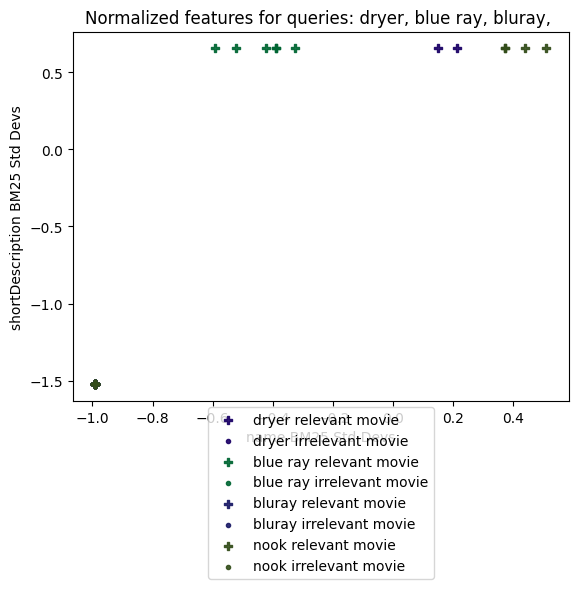

In [75]:
from plot import plot_judgments

plot_judgments(qids=[0,2,1,9], 
               xlabel="name BM25 Std Devs",
               ylabel="shortDescription BM25 Std Devs",
               title_prepend="Normalized features for queries:",
               judg_list=normed_judgments)

# Pairwise Transform

In [77]:
import numpy as np
from judgements import *

def pairwise_transform(normed_judgments, weigh_difference = True):
        
    from itertools import groupby
    predictor_deltas = []
    feature_deltas = []
    
    # For each query's judgments
    for qid, query_judgments in groupby(normed_judgments, key=lambda j: j.qid):

        # Annoying issue consuming python iterators, we ensure we have two
        # full copies of each query's judgments
        query_judgments_copy_1 = list(query_judgments) 
        query_judgments_copy_2 = list(query_judgments_copy_1)

        # Examine every judgment combo for this query, 
        # if they're different, store the pairwise difference:
        # +1 if judgment1 more relevant
        # -1 if judgment2 more relevant
        for judgment1 in query_judgments_copy_1:
            for judgment2 in query_judgments_copy_2:
                
                j1_features=np.array(judgment1.features)
                j2_features=np.array(judgment2.features)
                
                if judgment1.grade > judgment2.grade:
                    diff = judgment1.grade - judgment2.grade if weigh_difference else 1.0
                    predictor_deltas.append(+1)
                    feature_deltas.append(diff * (j1_features-j2_features))
                elif judgment1.grade < judgment2.grade:
                    diff = judgment2.grade - judgment1.grade if weigh_difference else 1.0
                    predictor_deltas.append(-1)
                    feature_deltas.append(diff * (j1_features-j2_features))

    # For training purposes, we return these as numpy arrays
    return np.array(feature_deltas), np.array(predictor_deltas)

feature_deltas, predictor_deltas = pairwise_transform(normed_judgments)

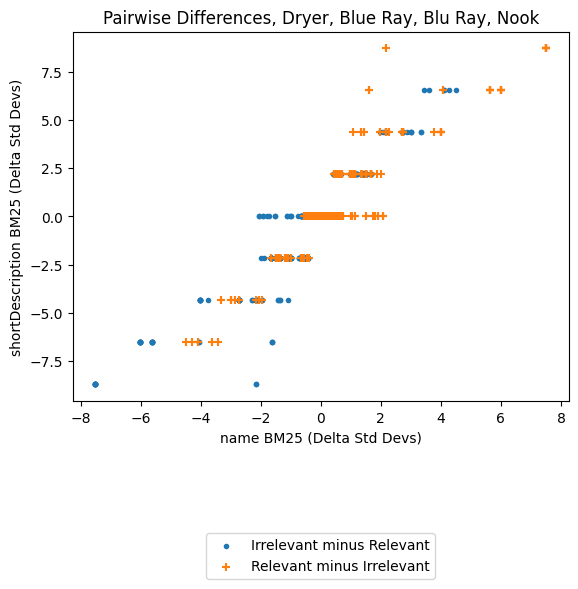

In [78]:
from plot import plot_pairwise_data

# Filter down to a judgment list of our two fav queries 
# out of the normalized data
just_these_queries = []
for j in normed_judgments:
    if j.qid == 0 or j.qid == 2 or j.qid == 1 or j.qid == 9:
        just_these_queries.append(j)

# Pairwise transform just these two, and plot
features, predictors = pairwise_transform(just_these_queries)
plot_pairwise_data(features, predictors,
                   xlabel="name BM25 (Delta Std Devs)",
                   ylabel="shortDescription BM25 (Delta Std Devs)",
                   title="Pairwise Differences, Dryer, Blue Ray, Blu Ray, Nook")

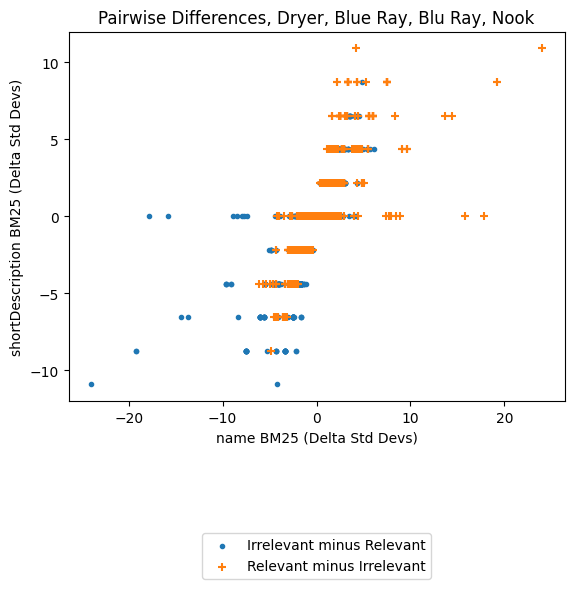

In [79]:
plot_pairwise_data(feature_deltas, predictor_deltas,
                   xlabel="name BM25 (Delta Std Devs)",
                   ylabel="shortDescription BM25 (Delta Std Devs)",
                   title="Pairwise Differences, Dryer, Blue Ray, Blu Ray, Nook")

# Training the model

In [80]:
from sklearn import svm
model = svm.LinearSVC(max_iter=10000, verbose=1)
model.fit(feature_deltas, predictor_deltas)
model.coef_

[LibLinear]

array([[0.05518517, 0.08975651]])

Uploading the model to Solr

In [81]:
import json

linear_model = {
  "store": "test",
  "class": "org.apache.solr.ltr.model.LinearModel",
  "name": "test_model",
  "features": [
  ],
  "params": {
      "weights": {
      }
  }
}

import math
ftr_model = {}
ftr_names = [ftr['name'] for ftr in feature_set]
for idx, ftr_name in enumerate(ftr_names):
    config = {
        "name": ftr_name,
        "norm": {
            "class": "org.apache.solr.ltr.norm.StandardNormalizer",
            "params": {
                "avg": str(means[idx]),
                "std": str(std_devs[idx])
            }
        }
    }
    linear_model['features'].append(config)
    linear_model['params']['weights'][ftr_name] =  model.coef_[0][idx] 

print(f"PUT {SOLR_URL}/solr/{products_collection}/schema/model-store")
print(json.dumps(linear_model, indent=2))

# Delete old model
resp = requests.delete(f"{SOLR_URL}/solr/{products_collection}/schema/model-store/test_model")


# Upload the model
resp = requests.put(f"{SOLR_URL}/solr/{products_collection}/schema/model-store", json=linear_model)
resp.text

PUT http://search-solr:8983/solr/solr/products/schema/model-store
{
  "store": "test",
  "class": "org.apache.solr.ltr.model.LinearModel",
  "name": "test_model",
  "features": [
    {
      "name": "name_bm25",
      "norm": {
        "class": "org.apache.solr.ltr.norm.StandardNormalizer",
        "params": {
          "avg": "2.121598189498525",
          "std": "2.142648674513569"
        }
      }
    },
    {
      "name": "name_constant",
      "norm": {
        "class": "org.apache.solr.ltr.norm.StandardNormalizer",
        "params": {
          "avg": "0.6991150442477876",
          "std": "0.45864277946371484"
        }
      }
    }
  ],
  "params": {
    "weights": {
      "name_bm25": 0.055185173040728695,
      "name_constant": 0.08975651138545801
    }
  }
}


''

See the result

In [82]:
from IPython.display import display,HTML
from searchutil import render_search_results

query = "transformers dvd"

collection = "products"
request = {
    "fields": ["upc", "name", "manufacturer", "score"],
    "limit": 5,
    "params": {
      "q": "{!ltr reRankDocs=60000 reRankWeight=2.0 model=test_model efi.keywords=\"" + query + "\"}",
      "qf": "name upc manufacturer shortDescription longDescription",
      "defType": "edismax",
      "q": query
    }
}

search_results = requests.post(f"{SOLR_URL}/{products_collection}/select", json=request).json()
display(HTML(render_search_results(query, search_results['response']['docs'])))